In [1]:
# import requests, StringIO, pandas as pd, json, re
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [2]:
#load in the tweet data
#tweetsdf = sqlContext.read.format('jdbc').options(url='jdbc:db2://awh-yp-small02.services.dal.bluemix.net:50000/BLUDB', user='dash111118', password='spJgsZAtvSvf',  dbtable='dash111118.MARRIOTT2_TWEETS').load()
#sentimentdf = sqlContext.read.format('jdbc').options(url='jdbc:db2://awh-yp-small02.services.dal.bluemix.net:50000/BLUDB', user='dash111118', password='spJgsZAtvSvf',  dbtable='dash111118.MARRIOTT2_SENTIMENTS').load()
#locationdf = sqlContext.read.format('jdbc').options(url='jdbc:db2://awh-yp-small02.services.dal.bluemix.net:50000/BLUDB', user='dash111118', password='spJgsZAtvSvf',  dbtable='dash111118.MARRIOTT2_LOCATIONS').load()

#load in the tweet data
tweetsdf = sqlContext.read.format('jdbc').options(url='jdbc:db2://awh-yp-small02.services.dal.bluemix.net:50000/BLUDB', user='dash111118', password='spJgsZAtvSvf',  dbtable='dash111118.HYATT_TWEETS').load()
sentimentdf = sqlContext.read.format('jdbc').options(url='jdbc:db2://awh-yp-small02.services.dal.bluemix.net:50000/BLUDB', user='dash111118', password='spJgsZAtvSvf',  dbtable='dash111118.HYATT_SENTIMENTS').load()
locationdf = sqlContext.read.format('jdbc').options(url='jdbc:db2://awh-yp-small02.services.dal.bluemix.net:50000/BLUDB', user='dash111118', password='spJgsZAtvSvf',  dbtable='dash111118.HYATT_LOCATIONS').load()

In [3]:
#import packages, instantiate dataframe, make cloudant connection, load cloudant data into dataframe
import requests, StringIO, pandas as pd, json, re

hyattlocations_df = sqlContext.read.format("com.cloudant.spark").\
option("cloudant.host","ajlevine.cloudant.com").\
option("cloudant.username", "ajlevine").\
option("cloudant.password","p").\
load("hyattlocations")

In [4]:
#test data for posterity
tweetsdf.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- MESSAGE_FAVORITES_COUNT: integer (nullable = true)
 |-- MESSAGE_INREPLYTO_URL: string (nullable = true)
 |-- MESSAGE_URL: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_RETWEET_COUNT: integer (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_ACTION: string (nullable = true)
 |-- MESSAGE_GENERATOR_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_COUNTRY: string (nullable = true)
 |-- MESSAGE_LOCATION_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- MESSAGE_COUNTRY_CODE: string (nullable = true)
 |-- USER_ID: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_DISPLAY_NAME: string (nullable = true)
 |-- USER_FAVORITES_COUNT: integer (nullable = true)
 |-- USER_FOLLOWERS_COUNT: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = tru

In [5]:
hyattlocations_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- areaCode: long (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- hotelID: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- metroCode: long (nullable = true)
 |-- postalCode: long (nullable = true)
 |-- region: string (nullable = true)



In [6]:
#convert tweet table to Pandas
tweetPD = tweetsdf.toPandas()
tweetPD['MESSAGE_ID'] = tweetPD['MESSAGE_ID'].map(lambda x: x.lstrip('tag:search.twitter.com,'))
tweetPD = tweetPD.set_index(tweetPD["MESSAGE_ID"])
tweetPD.drop(['MESSAGE_ID'], axis=1, inplace=True)
tweetPD.head(3)


,MESSAGE_BODY,MESSAGE_FAVORITES_COUNT,MESSAGE_INREPLYTO_URL,MESSAGE_URL,MESSAGE_POSTED_TIME,MESSAGE_RETWEET_COUNT,MESSAGE_LANGUAGE,MESSAGE_ACTION,MESSAGE_GENERATOR_DISPLAY_NAME,MESSAGE_COUNTRY,...,USER_REGISTER_TIME,USER_SCREEN_NAME,USER_STATUSES_COUNT,USER_SUMMARY,USER_CITY,USER_LOCATION_DISPLAY_NAME,USER_STATE,USER_COUNTRY,USER_COUNTRY_CODE,USER_SUB_REGION
MESSAGE_ID,,,,,,,,,,,,,,,,,,,,,
2005:601070999514128384,RT @BarbaraArmy: Barbara leaving the Grand Hya...,0,None,http://twitter.com/CCHEWO/statuses/60107099951...,2015-05-20 17:04:28,11,en,share,Twitter for Android,None,...,2010-09-30 13:18:17,CCHEWO,36961,kiyuki - ติดฟิคหนักมาก,Bangkok,"Bangkok, Thailand",Bangkok,Thailand,TH,None
2005:600511744470097921,Watch your mouth: The language we use creates ...,0,None,http://twitter.com/sarcastit/statuses/60051174...,2015-05-19 04:02:11,0,en,post,Tweet Jukebox,None,...,2014-08-31 09:30:15,sarcastit,9862,Legend in my own living room!! Searching for s...,None,Legend in my own living room,None,None,None,None
2005:600040926296350720,Hatun Grand Hyatt Cannes Hotel'de check-in ya...,0,None,http://twitter.com/muhammedgngr19/statuses/600...,2015-05-17 20:51:19,0,tr,post,Twitter Web Client,None,...,2013-03-24 19:32:52,muhammedgngr19,1052,Küçük gösteriyorum amk,None,None,None,None,None,None


In [7]:
#convert Sentiment table to Pandas
sentimentPD = sentimentdf.toPandas()
sentimentPD['MESSAGE_ID'] = sentimentPD['MESSAGE_ID'].map(lambda x: x.lstrip('tag:search.twitter.com,'))
sentimentPD = sentimentPD.set_index(sentimentPD["MESSAGE_ID"])
sentimentPD.drop(['MESSAGE_ID'], axis=1, inplace=True)
sentimentPD.head(3)

,SENTIMENT_POLARITY,SENTIMENT_TERM
MESSAGE_ID,,
2005:549051587520651264,POSITIVE,Enjoy
2005:546569756183379968,POSITIVE,great
2005:546569756183379968,POSITIVE,enjoy


In [8]:
#convert location table to Pandas

locationdf = locationdf.filter(locationdf['USER_LOCATION'] != "None")
locationPD = locationdf.toPandas()
locationPD['MESSAGE_ID'] = locationPD['MESSAGE_ID'].map(lambda x: x.lstrip('tag:search.twitter.com,'))
locationPD['USER_LOCATION'] = locationPD['USER_LOCATION'].map(lambda x: x.lstrip('POINT (').rstrip(')'))
locationPD = locationPD.set_index(locationPD["MESSAGE_ID"])
locationPD.drop(['MESSAGE_ID'], axis=1, inplace=True)
locationPD.drop(['MESSAGE_LOCATION'], axis=1, inplace=True)
locationPD.head(3)

,USER_LOCATION
MESSAGE_ID,
2005:541465985723531265,106.8451301 -6.2146200
2005:541467847981953024,120.0000000 -5.0000000
2005:541462694025371651,106.9896001 -6.2349000


In [9]:
hyattlocationsPD = hyattlocations_df.toPandas()

In [10]:
hyattlocationsPD.head(3)

,_id,_rev,areaCode,city,country,hotelID,latitude,longitude,metroCode,postalCode,region
0,f2665587412215b10f94b1982c7a5468,1-3f9899d0fe1e1152fd8a053357719b19,914,Valhalla,US,605,41.0877,-73.7768,501,10595,NY
1,f2665587412215b10f94b1982c7a63f8,1-98757615ae4bcda07eb34175113e6128,412,Pittsburgh,US,606,40.4406,-79.9959,508,15222,PA
2,f2665587412215b10f94b1982c7a6c05,1-9b03407922f1a9be10baba59661af62f,314,Bridgeton,US,607,38.7667,-90.4201,609,63044,MO


In [11]:
foo = lambda x: pd.Series([i for i in reversed(x.split(' '))])
rev = locationPD['USER_LOCATION'].apply(foo)

rev.rename(columns={0:'Latitude',1:'Longitude'},inplace=True)
rev = rev[['Latitude','Longitude']]

locationPD = locationPD.join(rev, on=None, how='inner')

locationPD.drop(['USER_LOCATION'], axis=1, inplace=True)

#create sentimentJoin
sentimentJoin = tweetPD.join(sentimentPD, on=None, how='inner')
sentimentJoin.head(3)




,MESSAGE_BODY,MESSAGE_FAVORITES_COUNT,MESSAGE_INREPLYTO_URL,MESSAGE_URL,MESSAGE_POSTED_TIME,MESSAGE_RETWEET_COUNT,MESSAGE_LANGUAGE,MESSAGE_ACTION,MESSAGE_GENERATOR_DISPLAY_NAME,MESSAGE_COUNTRY,...,USER_STATUSES_COUNT,USER_SUMMARY,USER_CITY,USER_LOCATION_DISPLAY_NAME,USER_STATE,USER_COUNTRY,USER_COUNTRY_CODE,USER_SUB_REGION,SENTIMENT_POLARITY,SENTIMENT_TERM
MESSAGE_ID,,,,,,,,,,,,,,,,,,,,,
2005:517465393057648642,Hyatt Regency Pier 66 Amid lush tropical acres...,0,None,http://twitter.com/Hotelsescape/statuses/51746...,2014-10-02 00:05:38,0,en,post,Sprout Social,None,...,1756,More hotels. More rates. More availability. Ho...,Orlando,Orlando,Florida,United States,US,Orange County,POSITIVE,lush
2005:517480253074452480,@MAliceTurner Thanks for joining us at the Gra...,0,http://twitter.com/MAliceTurner/statuses/51747...,http://twitter.com/HyattConcierge/statuses/517...,2014-10-02 01:04:41,0,en,post,Spredfast app,None,...,100200,HyattConcierge. Striving to make a difference ...,None,535+ properties. 47 countries,None,None,None,None,POSITIVE,Thanks
2005:517480253074452480,@MAliceTurner Thanks for joining us at the Gra...,0,http://twitter.com/MAliceTurner/statuses/51747...,http://twitter.com/HyattConcierge/statuses/517...,2014-10-02 01:04:41,0,en,post,Spredfast app,None,...,100200,HyattConcierge. Striving to make a difference ...,None,535+ properties. 47 countries,None,None,None,None,POSITIVE,Enjoy


In [12]:
#delete any records that contain Hyatt in the name

sentimentJoin = sentimentJoin[~sentimentJoin.USER_DISPLAY_NAME.str.contains('hyatt')]
sentimentJoin = sentimentJoin[~sentimentJoin.USER_DISPLAY_NAME.str.contains('Hyatt')]
sentimentJoin = sentimentJoin.join(locationPD, on=None, how='inner')



#sentimentJoin = sentimentJoin[~sentimentJoin.USER_DISPLAY_NAME.str.contains('marriott')]
#sentimentJoin = sentimentJoin[~sentimentJoin.USER_DISPLAY_NAME.str.contains('Marriott')]
#sentimentJoin = sentimentJoin.join(locationPD, on=None, how='inner')

In [13]:
del sentimentJoin['MESSAGE_FAVORITES_COUNT']
del sentimentJoin['MESSAGE_INREPLYTO_URL']
del sentimentJoin['MESSAGE_URL']
del sentimentJoin['MESSAGE_LANGUAGE']
del sentimentJoin['MESSAGE_GENERATOR_DISPLAY_NAME']
del sentimentJoin['USER_STATUSES_COUNT']
del sentimentJoin['USER_SUMMARY']
del sentimentJoin['MESSAGE_ACTION']
del sentimentJoin['MESSAGE_COUNTRY_CODE']
del sentimentJoin['USER_LISTED_COUNT']
del sentimentJoin['USER_SUB_REGION']
del sentimentJoin['USER_REGISTER_TIME']
del sentimentJoin['MESSAGE_RETWEET_COUNT']
del sentimentJoin['USER_GENDER']
#del sentimentJoin['USER_DISPLAY_NAME']
del sentimentJoin['USER_FAVORITES_COUNT']
del sentimentJoin['USER_IMAGE_URL']
del sentimentJoin['USER_URL']
#del sentimentJoin['USER_SCREEN_NAME']
del sentimentJoin['MESSAGE_COUNTRY']
del sentimentJoin['MESSAGE_LOCATION_DISPLAY_NAME']
del sentimentJoin['MESSAGE_LOCATION']
del sentimentJoin['USER_FOLLOWERS_COUNT']
del sentimentJoin['USER_FRIENDS_COUNT']
del sentimentJoin['USER_COUNTRY_CODE']


In [14]:
!pip install --user seaborn

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns

In [16]:
sentimentJoin['Latitude'] = sentimentJoin['Latitude'].astype(float)
sentimentJoin['Longitude'] = sentimentJoin['Longitude'].astype(float)

hyattlocationsPD['latitude'] = hyattlocationsPD['latitude'].astype(float)
hyattlocationsPD['longitude'] = hyattlocationsPD['longitude'].astype(float)

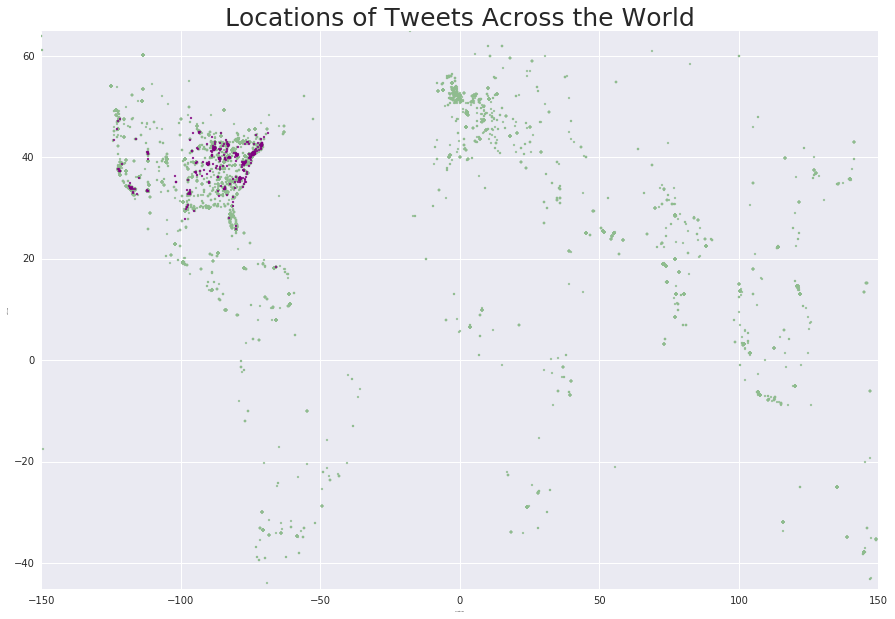

In [17]:
#adjust settings
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(sentimentJoin.Longitude, sentimentJoin.Latitude, alpha=.9, s=4, color='darkseagreen')
plt.scatter(hyattlocationsPD.longitude, hyattlocationsPD.latitude, alpha=.9, s=4, color='purple')


#adjust more settings
plt.title('Locations of Tweets Across the World', size=25)
plt.ylim((-45,65))
plt.xlim((-150,150))
plt.xlabel('Longitude',size=2)
plt.ylabel('Latitude',size=2)

plt.show()

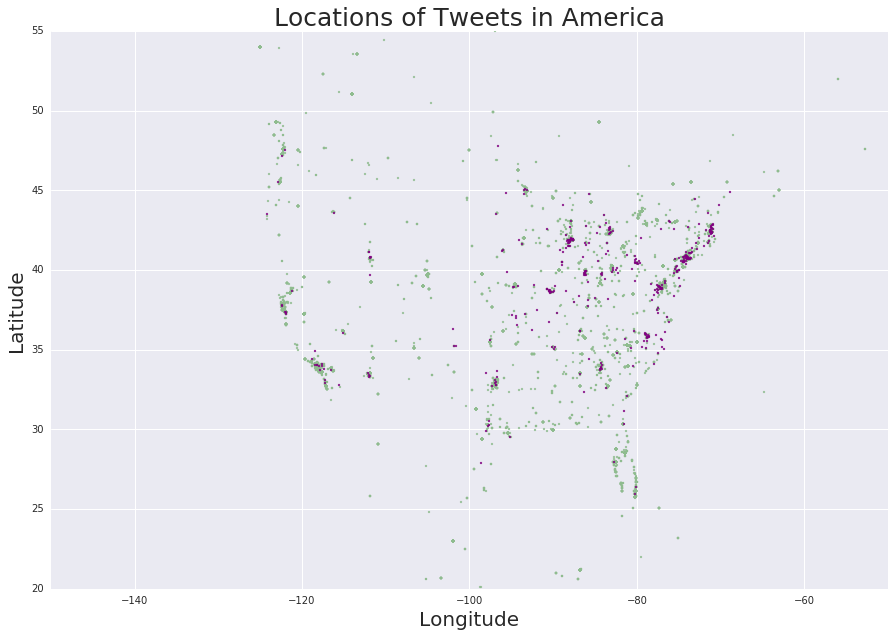

In [18]:
#adjust settings
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(sentimentJoin.Longitude, sentimentJoin.Latitude, alpha=.9, s=4, color='darkseagreen')
plt.scatter(hyattlocationsPD.longitude, hyattlocationsPD.latitude, alpha=.9, s=4, color='purple')



#adjust more settings
plt.title('Locations of Tweets in America', size=25)
plt.ylim((20,55))
plt.xlim((-150,-50))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)

plt.show()

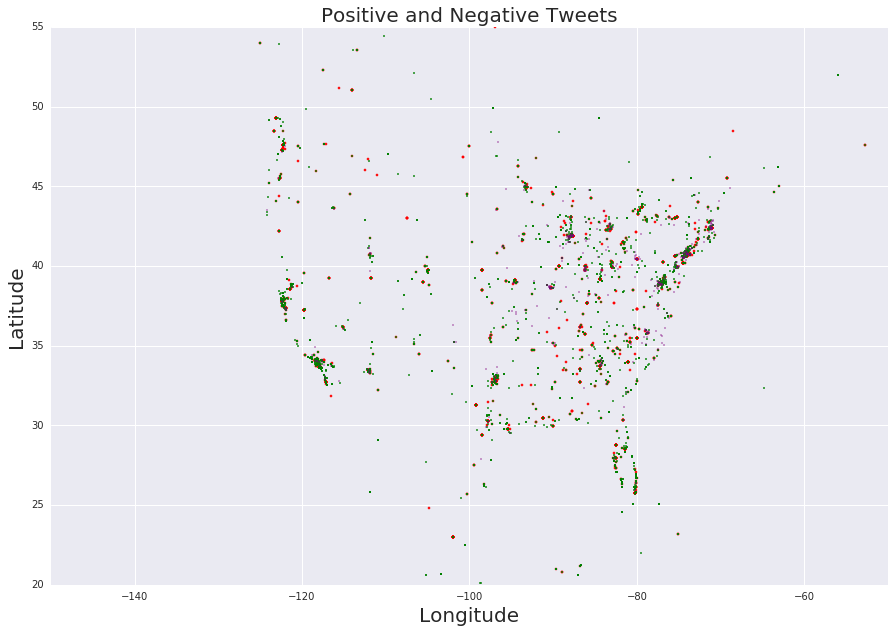

In [19]:
#break up into positive and negative tweets
positiveTweets = sentimentJoin[sentimentJoin.SENTIMENT_POLARITY.str.contains('POSITIVE')]
negativeTweets = sentimentJoin[sentimentJoin.SENTIMENT_POLARITY.str.contains('NEGATIVE')]

plt.figure(figsize=(15,10), dpi=0.1)

#create scatterplots
plt.scatter(negativeTweets.Longitude, negativeTweets.Latitude, color='red', s=20, marker ='.')
plt.scatter(positiveTweets.Longitude, positiveTweets.Latitude, s=10, color='green', marker ='.')
plt.scatter(hyattlocationsPD.longitude, hyattlocationsPD.latitude, alpha=.9, s=1, color='purple')


#create legend
red_patch = mpatches.Patch(color='red', label='Negative Tweets')
green_patch = mpatches.Patch(color='green', label='Positive Tweets')


#adjust more settings
plt.title('Positive and Negative Tweets', size=20)
plt.ylim((20,55))
plt.xlim((-150,-50))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

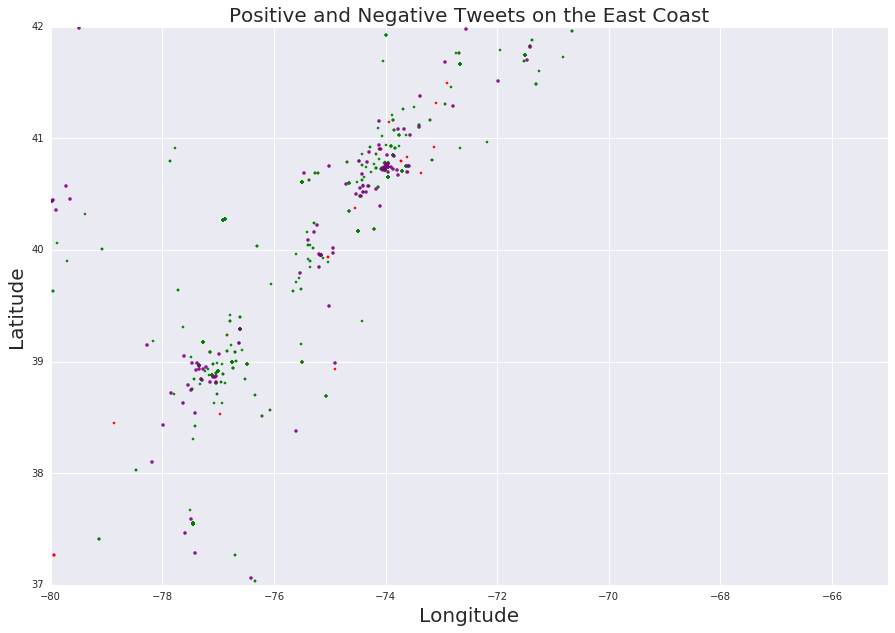

In [20]:
#break up into positive and negative tweets
positiveTweets = sentimentJoin[sentimentJoin.SENTIMENT_POLARITY.str.contains('POSITIVE')]
negativeTweets = sentimentJoin[sentimentJoin.SENTIMENT_POLARITY.str.contains('NEGATIVE')]

plt.figure(figsize=(15,10), dpi=0.1)

#create scatterplots
plt.scatter(negativeTweets.Longitude, negativeTweets.Latitude, color='red', s=20, marker ='.')
plt.scatter(positiveTweets.Longitude, positiveTweets.Latitude, s=20, color='green', marker ='.')
plt.scatter(hyattlocationsPD.longitude, hyattlocationsPD.latitude, alpha=.9, s=10, color='purple')


#create legend
red_patch = mpatches.Patch(color='red', label='Negative Tweets')
green_patch = mpatches.Patch(color='green', label='Positive Tweets')

#plt.legend([blue_patch, yellow_patch, red_patch, green_patch, black_patch],
   #        ('Manhattan', 'Bronx', 'Brooklyn', 'Staten Island', 'Queens'),
    #       loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Positive and Negative Tweets on the East Coast', size=20)
plt.ylim((37,42))
plt.xlim((-80,-65))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

In [21]:
!pip install --user tweepy

In [2]:
import tweepy

def get_api(cfg):
  auth = tweepy.OAuthHandler(cfg['consumer_key'], cfg['consumer_secret'])
  auth.set_access_token(cfg['access_token'], cfg['access_token_secret'])
  return tweepy.API(auth)

def sendDM(user,tweet):
  # Fill in the values noted in previous step here
  cfg = { 
    "consumer_key"        : "K7VAPBovHna6SD0fPXQliwYHJ",
    "consumer_secret"     : "SGERGBm75g6wdXYSXPS2dX4AOp0vAL6ijJpH9bQtSgAcobRy9o",
    "access_token"        : "3819023053-NXnJhvTK9ESnL43fuSeV6U3TXTn2WLHVs8ZLrTY",
    "access_token_secret" : "mnYM0j1uXu0nX758GjyS6DFTcZxx0OlWxGjW3thOQuulI" 
    }

  api = get_api(cfg)
  status = api.send_direct_message(screen_name=user,text=tweet) 
    


In [3]:
sendDM("ajlevine4e","We're Sorry you had a bad experience at a Hyatt Brand Hotel, Please take 10% off your next stay by using checkout code WERESORRY upon your next booking. For additional help, please contact us 24hours/day at 555-555-5555")
